# Willett Handwriting Dataset

In this tutorial, we will be going over the dataset associated with the landmark paper: [High-performance brain-to-text communication via handwriting](https://doi.org/10.1038/s41586-021-03506-2).

Willett et al. developed a method of converting an individual's thoughts to text. The data was collected as a part of the [Braingate initiative](https://www.braingate.org/). The authors showed that neural representation of handwriting, a fine motor skill that requires dexterous hand movement remained intact even after years of movement impairment.

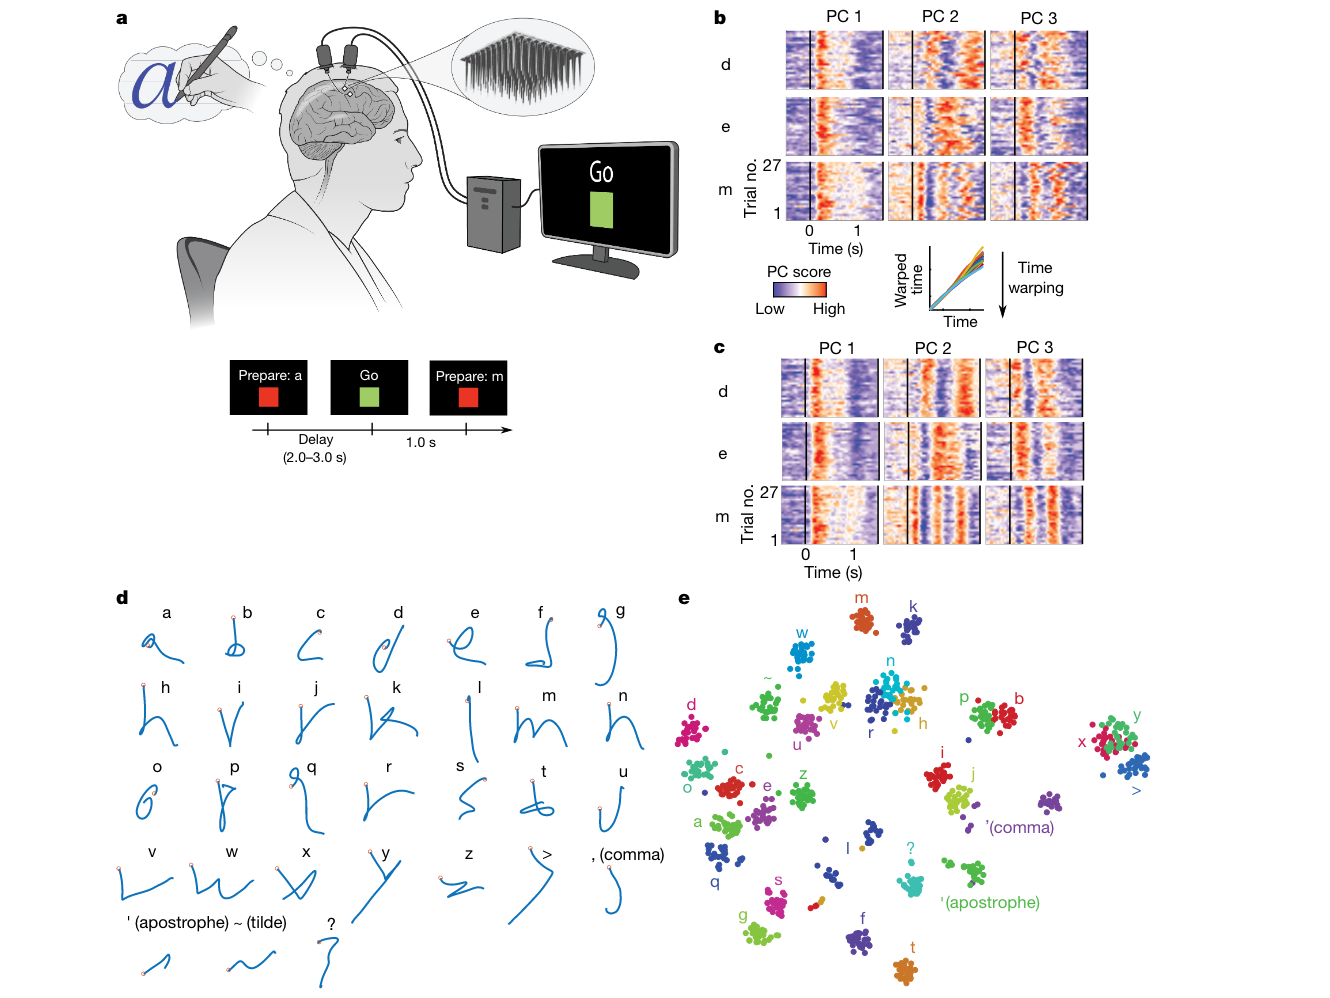

The data was collected from the patient T5, who has a high-level spinal injury and is hence, paralyzed neck-down. In the study, T5 was asked to imagine writing the prompted letter/word/sentance. The neural data obtained was then used to predict the character/word/sentence written.

## 1. Set up


### 1.1. Import Packages, initialize paths

In [ ]:
import os
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!gdown --folder https://drive.google.com/drive/folders/12zq88uHnHSAvadIkwF3NOl_XodihXrn5?usp=drive_link -O /content/Datasets

Retrieving folder list
Processing file 1Nc_5brAD2JxiLcdjDwTlnCwaSZ2HSgmf all_avg.csv
Processing file 19yH2XM55GSMF_2d_IrQKn3VmiOP9ZYHg all_data_192.csv
Processing file 1i3Lnwx923V67Y9-n8knwa-m1TLmUf6Ng all_data_192.npy
Processing file 13nJ9Dv2s3wbVRSKjQ94iI8n4XUutWyKL all_data_non_pca.csv
Processing file 1SgdDNpOQRcPpFi3NqbjMlGAYVpcV_4lc all_data.csv
Processing file 1FLsGm8k_9oVBTH13zzXGKzGQGRLdzwwS all_data.npy
Processing file 14xX3HxaKV8ODfVwPKwOWMDyiDpqPaFpy all_labels_new.csv
Processing file 1gInj09f72i7beaB6OVgB0d6u_oxhfTdp all_labels.csv
Processing file 13MTyjd__7WRRqXUupTHPfT1W5YJeus5h all_labels.npy
Processing file 1DadV4ppzfnwtMFR75uq6bs0vp09fphXG singleLetters.mat
Processing file 1f5t4UEM51GiAHErIfL9vSW2QnmvzJ5w4 t5.2019.05.08_warpedCubes.mat
Processing file 1uibR_8bX1FeY5_7BrzQdaZcc9gshdCFs X_transformed_best.npy
Processing file 13-gHr_bBBIr5KZmlAmZEd6-1rg-S6bYD X_transformed_new_1.npy
Processing file 1-2Ka0MpMVLc0HGcDTUtCNlPjR8sj7ZlN X_transformed_new.npy
Processing file 1W

In [ ]:
# Initialize the paths
DPATH = "/content/Datasets"
os.chdir(DPATH)

### 1.2. Support Functions

In [ ]:
def warping_distance_metric(x, y):
    """
    Warping distance metric to be used for t-SNE.
    Code adapted from Willet et al. 2021
    """
    timepoints_considered = 142
    neural_dims = y.size//timepoints_considered

    # Using the same linspace range as in the paper
    affine_wrap = np.linspace(0.7, 1.42, 15)

    # Reshape x like in MATLAB
    x = x.reshape(timepoints_considered, neural_dims, order="F")
    distance = np.zeros_like(affine_wrap)

    for idx, afw in enumerate(affine_wrap):
        # scipy interpolate structure:
        # actual x, actual y
        # locations were would would like to get the values
        interpolation = scipy.interpolate.interp1d(range(x.shape[0]), x, axis=0, kind="linear")
        x_interp = interpolation(np.linspace(0, x.shape[0]-1, int(x.shape[0]*afw)))

        # Reshape y like in MATLAB
        y = y.reshape(timepoints_considered, neural_dims, order="F")
        # Calculate the eucledian distance.
        # But only over the relevant time points.
        # If the affine warp value considered is over 1,
        # Then, we have to exclude the values that extend over timepoints_considered

        if afw > 1:
            diff = x_interp[:x.shape[0]] - y
        else:
            diff = x_interp - y[:x_interp.shape[0]]

        distance[idx] = np.linalg.norm(diff)
    return np.min(distance)

def plot_tsne_results(df):
    """
    Function to plot the t-SNE results
    """

    colors = [[0.3613, 0.8000,  0], [0.8000,  0, 0.1548], \
              [0.8000, 0.1548,  0], [0.8000,  0, 0.4645], \
              [0.6710,  0, 0.8000], [0.3613,  0, 0.8000], \
              [0.5161, 0.8000,  0], [0.8000, 0.6194,  0], \
              [0.8000,  0,  0], [0.6710, 0.8000,  0], \
              [0.2065,  0, 0.8000],  [0, 0.1032, 0.8000], \
              [0.8000, 0.3097,  0],  [0, 0.7226, 0.8000], \
              [0, 0.8000, 0.5677],  [0, 0.8000, 0.2581], \
              [0, 0.2581, 0.8000], [0.0516,  0, 0.8000], \
              [0.8000,  0, 0.6194], [0.8000, 0.4645,  0], \
              [0.8000,  0, 0.7742], [0.8000, 0.7742,  0], \
              [0, 0.5677, 0.8000], [0.8000,  0, 0.3097], \
              [0, 0.8000, 0.4129], [0.0516, 0.8000,  0], \
              [0, 0.4129, 0.8000], [0.5161,  0, 0.8000], \
              [0.2065, 0.8000,  0],  [0, 0.8000, 0.1032], \
              [0, 0.8000, 0.7226]]
    colors = np.array(colors)

    # Maping from the colors to the labels
    color_dict_mapping = {}
    unique_labels = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n", \
                     "o","p","q","r","s","t","u","v","w","x","y","z",">","comma", \
                     "'","~","?"]
    for idx in range(len(unique_labels)):
        color_dict_mapping[unique_labels[idx]] = colors[idx, :]

    # Plot away
    ax = plt.axes()
    for idx,char in enumerate(unique_labels):
        ax.scatter(df[df["label"]==char]["x"], df[df["label"]==char]["y"], \
                   c=colors[idx], alpha=0.5, label=char, edgecolor="white")

    # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", ncols=2)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title("t-SNE Distribution of the Characters based on Neural Data")
    ax.set_xlabel("")
    ax.set_ylabel("")
    label_points(ax, df, unique_labels)


def label_points(ax, df, unique_labels):
    a = pd.DataFrame()
    for i in unique_labels:
        a = pd.concat([a, pd.DataFrame({"x": [df[df["label"] == i]["x"].mean()], \
                      "y": [df[df["label"] == i]["y"].mean()], \
                      "val": [i]})], ignore_index=True)

    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

    plt.show()


def tsne_analysis(data, labels, distance_metric=warping_distance_metric):
    """
    Function to perform the t-SNE analysis (Figure 1e in thr paper).
    Given the input data, the function performs t-SNE dimensionality
    reduction on the data and plots the data in 2D space.

    Input:
        - data: Transformed neural data of dimensions (837, 2130) (i.e.)
                837 = 27*31 is from (number of trials (27) aross all characters (31)
                2130 = 142*15 is from (timepoints of interest after go cue (142), across all neural PC dimensions (15))
        - labels: Character label vector correposnding to the input datapoints of size 837
        - distance_metric: Metric to be used by t-SNE
    """
    # Check if t-SNE is already run for the data in question
    test_data = np.load(os.path.join(DPATH, "all_data_192.npy"))
    test_data = test_data.reshape((837, 142, 192), order='F')[:, :, :15]
    test_data = test_data.reshape((837, -1), order='F')
    print("Func:", test_data.shape)
    if np.all(np.isclose(test_data, data)):
        # In case the final output is already avaliable, use the
        # transformed data for the plot.
        # Note that the t-SNE function takes ~20 minutes to run when the
        # warping distance metric is used.
        if os.path.exists(os.path.join(DPATH, "X_transformed_best.npy")):
            X_transformed = np.load(os.path.join(DPATH, "X_transformed_best.npy"))
        else:
            print("Running t-SNE.\nNOTE: This will take a while (~20minutes)...")
            tsne = TSNE(n_components=2, perplexity=40, metric=distance_metric)
            X_transformed = tsne.fit_transform(data)
            np.save(os.path.join(DPATH, "X_transformed"), X_transformed)
    else:
        print("Running t-SNE.\nNOTE: This will take a while (~20minutes)...")
        tsne = TSNE(n_components=2, perplexity=40, metric=distance_metric)
        X_transformed = tsne.fit_transform(data)
        np.save(os.path.join(DPATH, "X_transformed"), X_transformed)


    df = pd.DataFrame()
    df["x"] = X_transformed[:, 0]
    df["y"] = X_transformed[:, 1]
    df["label"] = labels

    # Plot the results
    plot_tsne_results(df)

    return df

def plot_pc_data(data, labels, select_chars_idx=[3, 4, 11], num_chars=31, \
                 time_considered=142, num_repeats=27, n_dims=3):
    """
    Visualize the top 3 PCs, given the index of the characters.
    """
    viz_data = data.copy()
    viz_data = data.reshape((837, 142, 192), order='F')
    viz_data = viz_data[:, :, :3]

    avg_data_all = np.zeros((num_chars, time_considered, n_dims))

    # Select a small subset of characters to plot
    for i in select_chars_idx:
        char_data = viz_data[i*num_repeats:(i+1)*num_repeats]
        avg_data_all[i] = char_data.mean(axis=0)

        plt.figure(figsize=(18, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(char_data[:, :, 0], cmap="bwr", aspect="auto")
        plt.xlabel("Time")
        plt.ylabel("Repeats")
        plt.subplot(1, 3, 2)
        plt.imshow(char_data[:, :, 1], cmap="bwr", aspect="auto")
        plt.xlabel("Time")
        plt.subplot(1, 3, 3)
        plt.imshow(char_data[:, :, 2], cmap="bwr", aspect="auto")
        plt.xlabel("Time")

        plt.suptitle("Neural Activity across 3 PCs; Character: {}".format(labels[i*num_repeats]))
        plt.tight_layout()
        plt.show()

def get_warped_data(DPATH="/content/Datasets"):
    scipy_data = scipy.io.loadmat(os.path.join(DPATH, "t5.2019.05.08_warpedCubes.mat"))
    selected_data = {i:j for i,j in scipy_data.items() if "_" not in i}
    for idx, i in enumerate(selected_data):
        if idx == 0:
            data_mat = selected_data[i]
        else:
            data_mat = np.vstack([data_mat, selected_data[i]])

    print(data_mat.shape)
    np.save(os.path.join(DPATH, "warped_all_data"), data_mat)

    # Get the averaged data for each character too
    selected_data = {i:j for i,j in scipy_data.items() if "_T" in i}
    for idx, i in enumerate(selected_data):
        if idx == 0:
            data_mat = selected_data[i]
            print(selected_data[i].shape)
        else:
            data_mat = np.vstack([data_mat, selected_data[i]])

    print(data_mat.shape)
    np.save(os.path.join(DPATH, "warped_avg_all_data"), data_mat)

def plot_warped_data(n_dims=3, select_chars_idx=[3, 4, 12], DPATH="/content/Datasets"):
    if not os.path.exists(os.path.join(DPATH, "warped_all_data.npy")):
        get_warped_data

    data = np.load(os.path.join(DPATH, "warped_all_data.npy"))
    data = data[:, 59:, :]
    data = data.reshape((-1, 192), order='F')
    data = np.nan_to_num(data)

    labels = pd.read_csv(os.path.join(DPATH, "all_labels_new.csv"), index_col=0)["labels"]
    labels = labels.values

    # Perform PCA on the data
    pca = PCA()
    pca.fit(data)
    pca_data = pca.transform(data)

    plot_pc_data(pca_data, labels, select_chars_idx=select_chars_idx, n_dims=n_dims)

def plot_neural_trajectories(data, labels, samples_idx=[3, 4, 12], n_dims=2):
    data = np.load(os.path.join(DPATH, "warped_all_data.npy"))

    if n_dims not in [2, 3]:
        raise Exception("""We all want to see the data in higher dimensions. But, we are kinda restricted to 2 and 3 dimensions at the minute.
            Here's a quote from Geoffrey Hinton:
            To deal with hyper-planes in a 14-dimensional space, visualize a 3-D space and say 'fourteen' to yourself very loudly. Everyone does it.""")
    elif n_dims==2:
        plt.figure()
        for i in samples_idx:
            print(i)
            plt.plot(data[i*num_repeats, 59:, 0], data[i*num_repeats, 59:, 1], alpha=0.7, label=labels[i])

        plt.grid(True)
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.title("Neural Trajectory")
        plt.legend()
        plt.show()

## 2. Load Dataset

In [ ]:
# Load data and initialize some important values
data = np.load(os.path.join(DPATH, "all_data_192.npy"))
labels = pd.read_csv(os.path.join(DPATH, "all_labels_new.csv"), index_col=0)["labels"]
labels = labels.values

num_chars = 31
time_considered = 142
num_repeats = data.shape[0]//num_chars
neural_dims = data.shape[1]//time_considered

print("Dimensions of Data: {}, {}".format(data.shape, labels.shape))
print("Number of Characters: {}; Number of repeats/character: {}".format(num_chars, num_repeats))
print("Number of Neurons: {}".format(neural_dims))

Dimensions of Data: (837, 27264), (837,)
Number of Characters: 31; Number of repeats/character: 27
Number of Neurons: 192


### 2.1. Visualize the Dataset

Now that we have the dataset, let's visualize it.

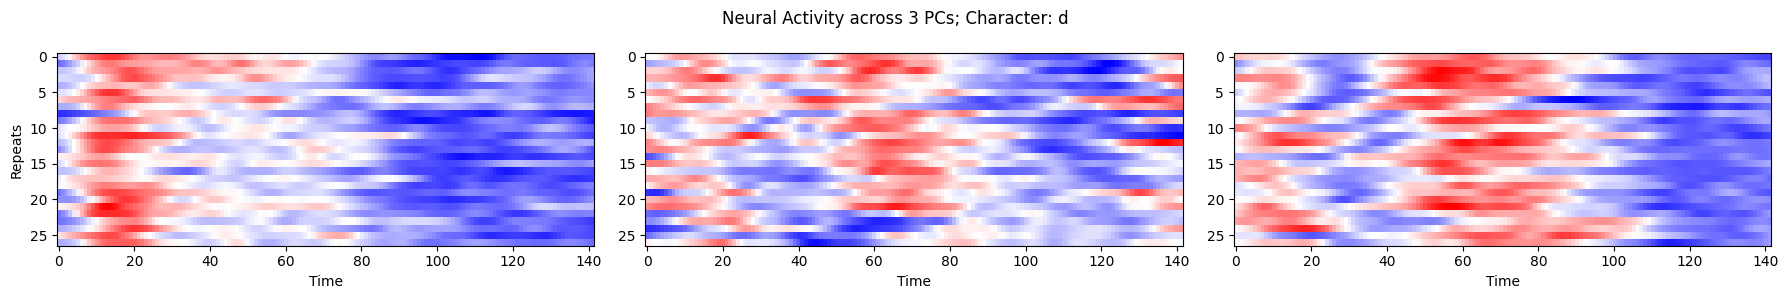

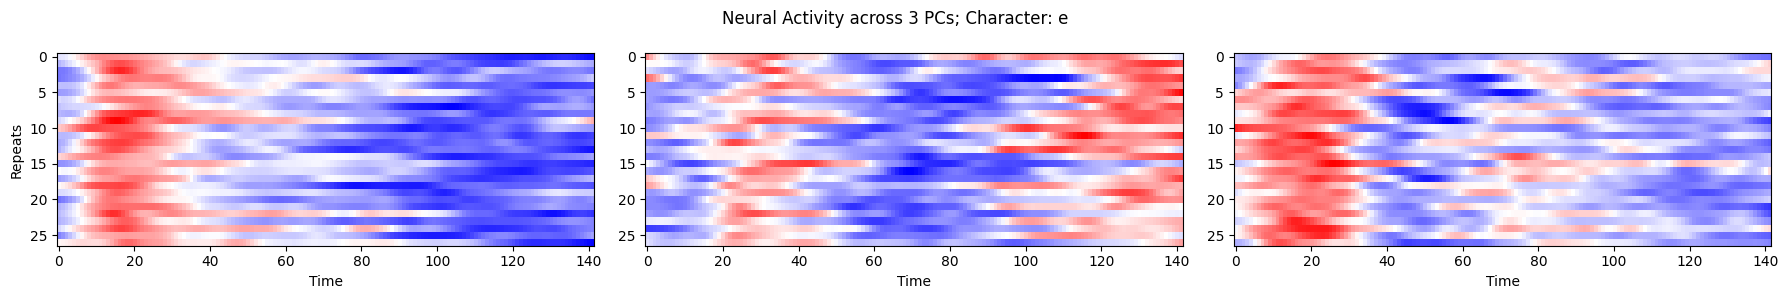

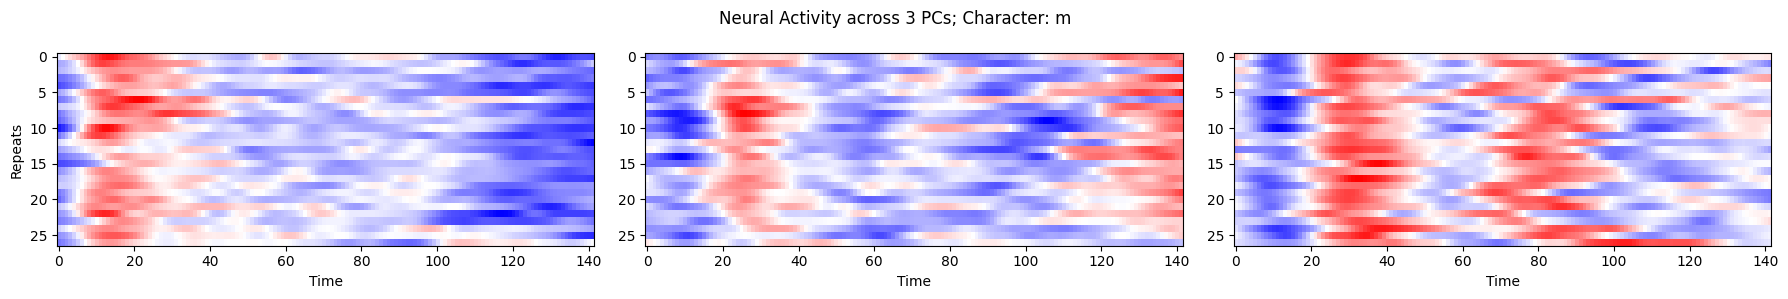

In [ ]:
# Visualize the neural data of characters D, E and M.
select_chars_idx = [3, 4, 12]
plot_pc_data(data, labels, select_chars_idx)

### 2.2. Warp the Dataset

While there seems to be some structure in the dataset, we see that there is a lot of variation across trials. There are multiple approaches to solving this:
1. The most simple approach is just aligning the data using a time event such as the "go" cue as a landmark. However, in this case, the data points closest to the landmark will be well aligned and data points farther away from it will deviate.
2. An alternate approach is to warp the data such that they are aligned across trials. In case of warping, usually a function is fit for the data and interpolations/extrapolations are performed on the data.

Now, let's apply a warping approach on the dataset and verify how the data changes.

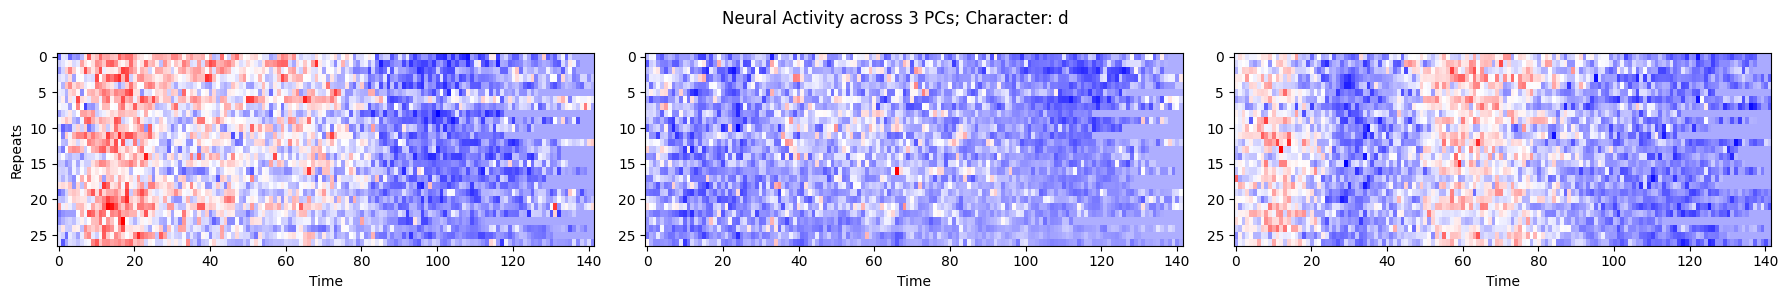

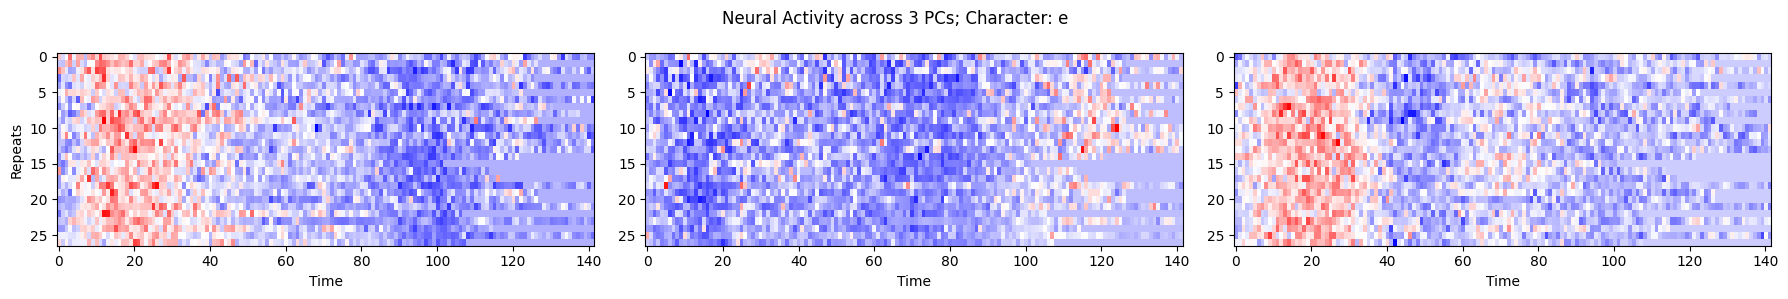

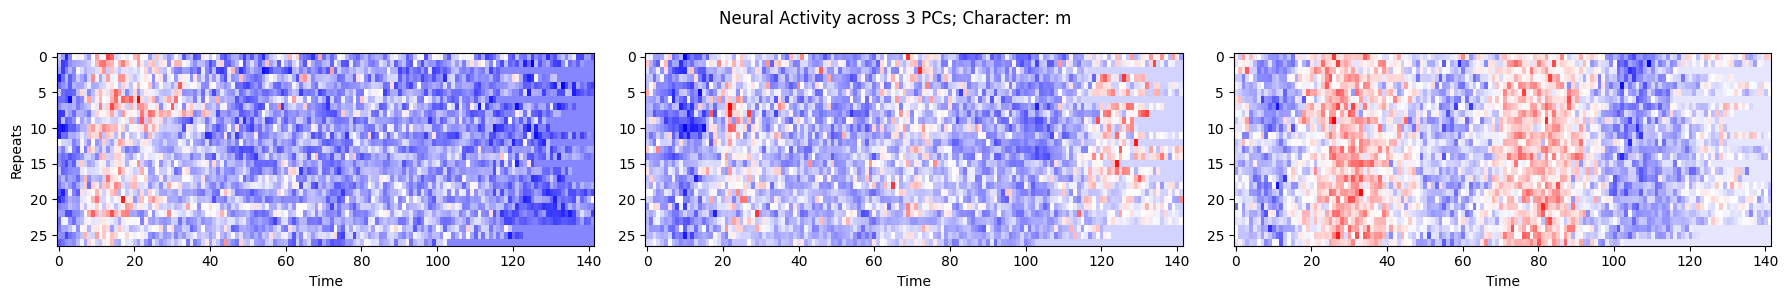

In [ ]:
n_dims = 3
select_chars_idx = [3, 4, 12]

plot_warped_data(select_chars_idx=select_chars_idx)

### 2.3. t-SNE Analysis

Now that we see some structure in the dataset, let's visualize how the data looks in lower dimensions. We will be using a non-linear dimensionality method called t-SNE (t-distributed Stochastic Neighbor Embedding).

**A Brief Introduction of t-SNE**  
1. t-SNE meausres the pairwise *similarity* between datapoints in high dimensional space using a Gaussian Distribution.
2. t-SNE constructs a lower dimensional space in such a way that the high-dimensional similarities are (mostly) preserved in the new low-dimensional space.
3. The final low-dimensional space is obtained through graident descent. <font color='red'>As the approach itself is stochastic, we will obtain results that differ during each run.</font> Try to identify clusters that differ from the original paper.


In order to make the analysis a little faster, we will only be considering the top 15 dimensions of the PCA transformed data for the t-SNE analysis.

(837, 2130)
Func: (837, 2130)


<ipython-input-5-c390c9cf2180>:72: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[df["label"]==char]["x"], df[df["label"]==char]["y"], \


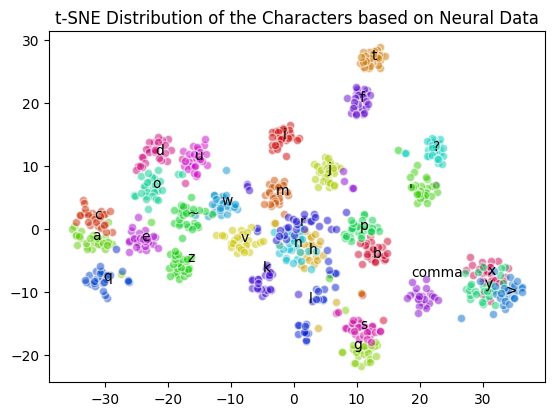

In [ ]:
low_d_transform = data.reshape((837, 142, 192), order='F')[:, :, :15].reshape((837, -1), order='F')
print(low_d_transform.shape)
df = tsne_analysis(low_d_transform, labels, distance_metric=warping_distance_metric)

### 2.3. Visualize Neural Trajectories

Now we know that there is clearly some structure in the dataset. Let's do a small refresher of neural trajectories before we jump into this.

**What are neural trajectories?**  
They are representation of neural data that help us understand how the response of differnt neurons/population of neurons vary over time. The usual approach to study neural trajectories is to first reducte the dimensionality of the data and then plot the trajectories in lower dimensions.

In [ ]:
new_data = data.reshape((837, -1, 192), order='F')

3
4
12


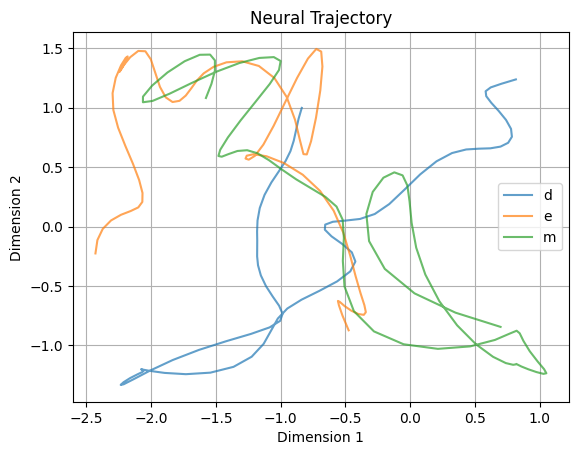

3
4
12


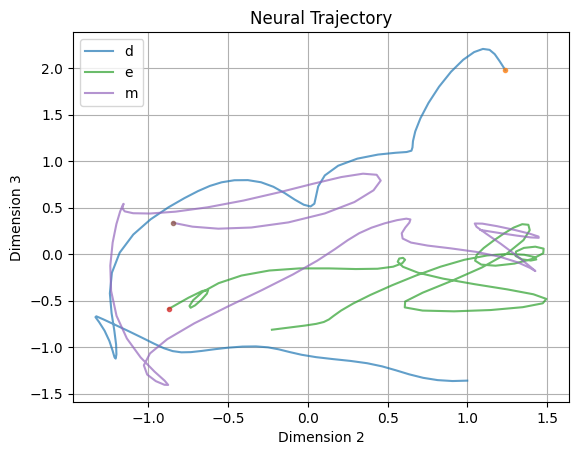

In [ ]:
samples_idx = [3, 4, 12]
unique_labels = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n", \
                     "o","p","q","r","s","t","u","v","w","x","y","z",">","comma", \
                     "'","~","?"]

plt.figure()
for i in samples_idx:
    plt.plot(new_data[i*num_repeats, 59:, 0], new_data[i*num_repeats, 59:, 1], alpha=0.7, label=unique_labels[i])

plt.grid(True)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Neural Trajectory")
plt.legend()
plt.show()

plt.figure()
for i in samples_idx:
    plt.plot(new_data[i*num_repeats, 59:, 1], new_data[i*num_repeats, 59:, 2], alpha=0.7, label=unique_labels[i])
    plt.plot(new_data[i*num_repeats, 59, 1], new_data[i*num_repeats, 59, 2], '.', alpha=0.7)

plt.grid(True)
plt.xlabel("Dimension 2")
plt.ylabel("Dimension 3")
plt.title("Neural Trajectory")
plt.legend()
plt.show()